In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using GPU: NVIDIA GeForce RTX 4090


# Find Game Paths

In [3]:
from npz_loader import discover_games

game_paths = discover_games(Path("dataset/"))
print("\n".join(str(p) for p in game_paths))

dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4
dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4
dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4
dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4
dataset\PongNoFrameskip-v4\PongNoFrameskip-v4
dataset\QbertNoFrameskip-v4\QbertNoFrameskip-v4
dataset\SeaquestNoFrameskip-v4\SeaquestNoFrameskip-v4
dataset\SpaceInvadersNoFrameskip-v4\SpaceInvadersNoFrameskip-v4


# Load NPZ Files in to Dict

In [4]:
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths
from pprint import pprint

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")

print(f"Loaded games:")
for game in sequences_by_game.keys():
    print(f"\t{game}")
    print(f"\t\tNumber of sequences: {len(sequences_by_game[game])}")

one_game_key = list(sequences_by_game.keys())[0]
one_game_seq_list = sequences_by_game[one_game_key]
one_game_seq = one_game_seq_list[0]

print(f"Keys in one_game_seq ({type(one_game_seq)}):")

one_row = []
for key in one_game_seq.keys():
    arr = one_game_seq[key]
    print(f"\t{key}:")
    print(f"\t\tshape={arr.shape}")
    print(f"\t\tdtype={arr.dtype}")

    row_to_print = 10
    if len(one_game_seq[key]) > 1:
        one_row.append(f"{key}: {one_game_seq[key][row_to_print]}")
    else:
        one_row.append(f"{key}: {one_game_seq[key][0]}")
        

Loaded games:
	dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4
		Number of sequences: 200
	dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4
		Number of sequences: 200
Keys in one_game_seq (<class 'dict'>):
	model selected actions:
		shape=(548, 1)
		dtype=int64
	taken actions:
		shape=(548, 1)
		dtype=int64
	obs:
		shape=(548,)
		dtype=<U193
	rewards:
		shape=(548,)
		dtype=float64
	episode_returns:
		shape=(1,)
		dtype=float64
	episode_starts:
		shape=(548,)
		dtype=bool
	repeated:
		shape=(548,)
		dtype=bool


Total sequences available: 400

Calculating metrics from all sequences...


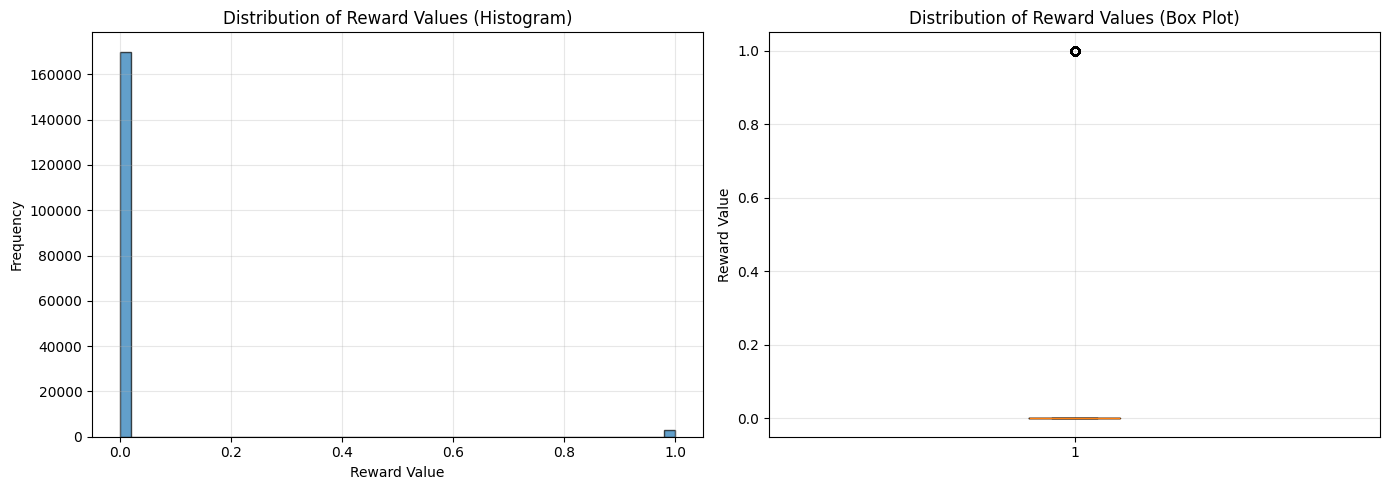


Overall reward statistics across ALL sequences:
  Total reward values: 172827
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0162
  Median: 0.0000
  Std: 0.1263

Randomly selected sequence:
  Game: dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4
  Sequence length: 153
  Rewards array: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Reward stats - min: 0.0000, max: 1.0000, mean: 0.0261, std: 0.1596


In [5]:
# Analyze reward sequences
import random

# Collect all sequences from all games
all_sequences = []
for game, seqs in sequences_by_game.items():
    for seq in seqs:
        all_sequences.append((game, seq))

print(f"Total sequences available: {len(all_sequences)}")

# Calculate metrics from ALL sequences
print("\nCalculating metrics from all sequences...")
all_rewards = []  # Collect all rewards for distribution plot
for game, seq in all_sequences:
    rewards = seq["rewards"]
    all_rewards.extend(rewards.tolist())

# Create plot of reward value distribution using all sequences
all_rewards = np.array(all_rewards)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(all_rewards, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Reward Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Reward Values (Histogram)')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(all_rewards, vert=True)
axes[1].set_ylabel('Reward Value')
axes[1].set_title('Distribution of Reward Values (Box Plot)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall reward statistics across ALL sequences:")
print(f"  Total reward values: {len(all_rewards)}")
print(f"  Min: {all_rewards.min():.4f}")
print(f"  Max: {all_rewards.max():.4f}")
print(f"  Mean: {all_rewards.mean():.4f}")
print(f"  Median: {np.median(all_rewards):.4f}")
print(f"  Std: {all_rewards.std():.4f}")

# Randomly select 1 sequence to print
random.seed(42)  # For reproducibility
selected_idx = random.randint(0, len(all_sequences) - 1)
selected_game, selected_seq = all_sequences[selected_idx]
rewards = selected_seq["rewards"]

print("\n" + "="*100)
print("Randomly selected sequence:")
print("="*100)
print(f"  Game: {selected_game}")
print(f"  Sequence length: {len(rewards)}")
print(f"  Rewards array: {rewards}")
print(f"  Reward stats - min: {rewards.min():.4f}, max: {rewards.max():.4f}, mean: {rewards.mean():.4f}, std: {rewards.std():.4f}")
